In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from transformers.ColumnDropper import ColumnDropper
from transformers.FeatureEnginnering import FeatureEnginnering

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import optuna

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Hipotesis y formulacion

1. Lo mas probable es que el problema este basado en un desbalance fuerte de clases.
2. El modelamiento del problema debe estar guiado mas en maximizar que en precisar , es decir ya que existe un costo alto por errar en la clasificacion se deben usar tecnicas y/o metodos que maximizen el nivel de clasificacion para transacciones non_fraudimas sin perder el factor de "aprendizaje" buscando un objetivo concreto (numero de transacciones , ganancia o perdida , etc ...)
3. Hay que responder ciertas preguntas : ¿ existe alguna relacion de fechas y/o horas que marquen un patron de fraude ? , ¿ el monto marca algun patron hacia el fraude ? , ¿ relaciones multivariadas muestran alguna relacion hacia el fraude?

### Hipotesis:
 - ¿ Las transacciones con mayor monto tienden a ser las mas riesgosas a ser fraudulentas.?
 - ¿ Existe una relacion lineal entre el score y el Monto ?
 - ¿ En altas horas de la noche o madrugada tienden a haber mas transacciones fraudulentas. ?
 - ¿ Fines de semana de noche concentran riesgo ?
 - ¿ Las transacciones fraudulentas llevan un comportamiento similar a las no fraudulentas pero en mayor nivel (valores mas altos) ?
 - ¿ Eliminación agresiva de outliers reduce recall de fraude ?
 - ¿ Existe algun tipo de estacionalidad en el fraude ?

# EDA

* Conociendo el dataset

In [2]:
csv_path = "data.csv" 
df = pd.read_csv(csv_path)

print(df.shape)
df.head()

(150000, 19)


,a,b,c,d,e,f,g,h,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.6812,50084.12,50.0,0.000000,20.0,AR,1,cat_d26ab52,0.365475,2479.0,952.0,1,NaN,Y,2020-03-20 09:28:19,57.63,100,0
1,4,0.6694,66005.49,0.0,0.000000,2.0,AR,1,cat_ea962fb,0.612728,2603.0,105.0,1,Y,Y,2020-03-09 13:58:28,40.19,25,0
2,4,0.4718,7059.05,4.0,0.463488,92.0,BR,25,cat_4c2544e,0.651835,2153.0,249.0,1,Y,Y,2020-04-08 12:25:55,5.77,23,0
3,4,0.7260,10043.10,24.0,0.046845,43.0,BR,43,cat_1b59ee3,0.692728,4845.0,141.0,1,N,Y,2020-03-14 11:46:13,40.89,23,0
4,4,0.7758,16584.42,2.0,0.154616,54.0,BR,0,cat_9bacaa5,0.201354,2856.0,18.0,1,Y,N,2020-03-23 14:17:13,18.98,71,0


In [27]:
df.shape

(150000, 19)

In [28]:
df.dtypes

a           int64
b         float64
c         float64
d         float64
e         float64
f         float64
g          object
h           int64
j          object
k         float64
l         float64
m         float64
n           int64
o          object
p          object
fecha      object
monto     float64
score       int64
fraude      int64
dtype: object

In [126]:
TARGET = "fraude"
AMOUNT = "monto"
TIME = "fecha"
PALETTE = {0: "#ffe600", 1: "#D70505"}

* missing values

In [30]:
df

,a,b,c,d,e,f,g,h,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.6812,50084.12,50.0,0.000000,20.0,AR,1,cat_d26ab52,0.365475,2479.0,952.0,1,NaN,Y,2020-03-20 09:28:19,57.63,100,0
1,4,0.6694,66005.49,0.0,0.000000,2.0,AR,1,cat_ea962fb,0.612728,2603.0,105.0,1,Y,Y,2020-03-09 13:58:28,40.19,25,0
2,4,0.4718,7059.05,4.0,0.463488,92.0,BR,25,cat_4c2544e,0.651835,2153.0,249.0,1,Y,Y,2020-04-08 12:25:55,5.77,23,0
3,4,0.7260,10043.10,24.0,0.046845,43.0,BR,43,cat_1b59ee3,0.692728,4845.0,141.0,1,N,Y,2020-03-14 11:46:13,40.89,23,0
4,4,0.7758,16584.42,2.0,0.154616,54.0,BR,0,cat_9bacaa5,0.201354,2856.0,18.0,1,Y,N,2020-03-23 14:17:13,18.98,71,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,4,0.7728,34031.44,3.0,0.341379,18.0,BR,18,cat_039c51f,0.685681,2475.0,39.0,1,N,N,2020-04-11 17:25:30,5.47,37,0
149996,4,0.7569,81957.82,50.0,1.492911,5.0,BR,4,cat_fd8d8c5,0.669857,1073.0,672.0,1,NaN,Y,2020-03-22 08:46:51,2.53,8,0
149997,4,0.7012,77840.16,34.0,0.179331,3.0,BR,32,cat_ecc6934,0.315430,2497.0,219.0,1,NaN,Y,2020-04-09 11:35:40,6.28,57,0
149998,2,0.7206,31001.65,50.0,0.000000,50.0,UY,31,cat_851cfbb,0.813346,3952.0,84.0,1,NaN,N,2020-04-19 17:48:17,40.52,0,0


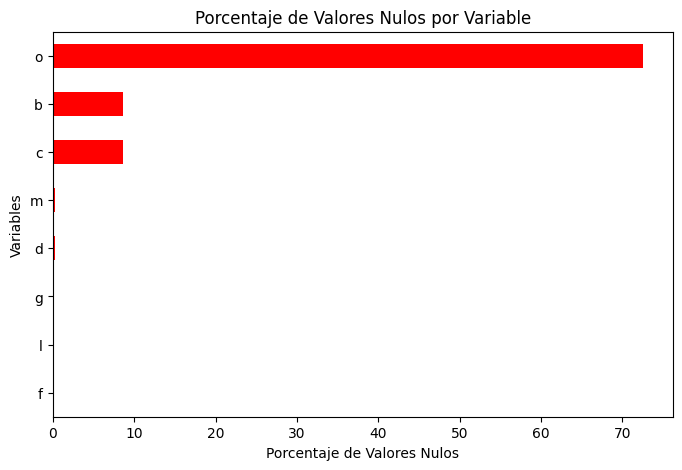

In [ ]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_percentage = missing_percentage[missing_percentage > 0]

plt.figure(figsize=(8,5))
missing_percentage.sort_values().plot(kind='barh', color='red')
plt.xlabel("Porcentaje de Valores Nulos")
plt.ylabel("Variables")
plt.title("Porcentaje de Valores Nulos por Variable")
plt.show()

In [32]:
df.drop(columns=["o"], inplace=True)

hay columnas con un alto indice de valores faltantes (o) columnas que se pueden eliminar , las demas columnas que tienen valores faltantes pueden tener una imputacion de datos usando la media

In [ ]:
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)
df[AMOUNT] = pd.to_numeric(df[AMOUNT], errors="coerce")
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

In [34]:
# limpieza y extraccion de fecha
# mapear strings a binarios

df[TIME] = pd.to_datetime(
    df[TIME],
    errors="coerce",
    infer_datetime_format=True,
    utc=True
)

df["fecha_date"] = df[TIME].dt.date
df["day"] = df[TIME].dt.day
df["hour"]= df[TIME].dt.hour
df["dow"] = df[TIME].dt.dayofweek

def yn_to_bin(col):
    s = col.astype("string").str.strip().str.upper()
    return s.map({"Y": 1, "N": 0}).astype("Int8")

df["p_bin"]  = yn_to_bin(df["p"])

/tmp/ipykernel_101863/806975448.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME] = pd.to_datetime(


In [35]:
df.describe()

,a,b,c,d,e,f,h,k,l,m,n,monto,score,fraude,day,hour,dow,p_bin
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579,0.902353,43.523134,48.066240,0.050000,15.282533,14.139447,2.701027,0.554193
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806,0.296837,91.557888,28.995122,0.217946,7.108072,5.082165,2.011242,0.497056
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000,1.000000,9.380000,23.000000,0.000000,10.000000,10.000000,1.000000,0.0
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000,1.000000,20.610000,48.000000,0.000000,15.000000,14.000000,3.000000,1.0
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000,1.000000,40.692500,73.000000,0.000000,20.000000,18.000000,4.000000,1.0
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000,1.000000,3696.350000,100.000000,1.000000,31.000000,23.000000,6.000000,1.0


In [36]:
df.head()

,a,b,c,d,e,f,g,h,j,k,...,p,fecha,monto,score,fraude,fecha_date,day,hour,dow,p_bin
0,4,0.6812,50084.12,50.0,0.000000,20.0,AR,1,cat_d26ab52,0.365475,...,Y,2020-03-20 09:28:19+00:00,57.63,100,0,2020-03-20,20,9,4,1
1,4,0.6694,66005.49,0.0,0.000000,2.0,AR,1,cat_ea962fb,0.612728,...,Y,2020-03-09 13:58:28+00:00,40.19,25,0,2020-03-09,9,13,0,1
2,4,0.4718,7059.05,4.0,0.463488,92.0,BR,25,cat_4c2544e,0.651835,...,Y,2020-04-08 12:25:55+00:00,5.77,23,0,2020-04-08,8,12,2,1
3,4,0.7260,10043.10,24.0,0.046845,43.0,BR,43,cat_1b59ee3,0.692728,...,Y,2020-03-14 11:46:13+00:00,40.89,23,0,2020-03-14,14,11,5,1
4,4,0.7758,16584.42,2.0,0.154616,54.0,BR,0,cat_9bacaa5,0.201354,...,N,2020-03-23 14:17:13+00:00,18.98,71,0,2020-03-23,23,14,0,0


### Distribucion de variables iniciales

In [52]:
df["a"] = df["a"].astype("category")
df["g"] = df["g"].astype("category")
def is_binary(s):
    vals = pd.unique(pd.to_numeric(s, errors="coerce").dropna())
    return len(vals) <= 2 and set(vals).issubset({0,1})

num_cols = [c for c in df.select_dtypes(include=["number"]).columns if c != TARGET]
bin_cols  = [c for c in num_cols if is_binary(df[c])]
cont_cols = [c for c in num_cols if c not in bin_cols]

* Variables binarias (Univariado)

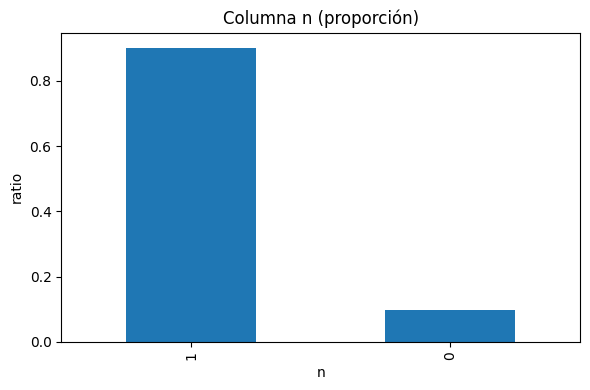

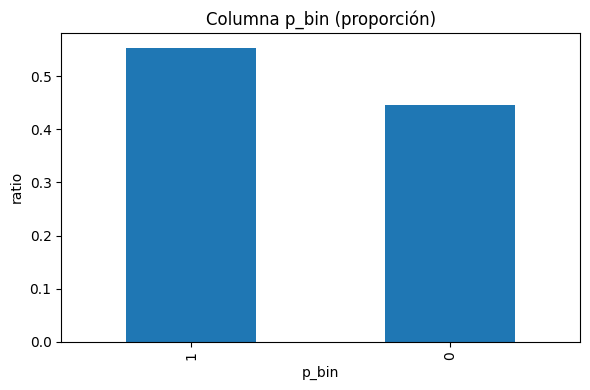

In [ ]:

for col in bin_cols:
    values = df[col].value_counts(dropna=False)
    plt.figure(figsize=(6,4))
    (values / values.sum()).plot(kind="bar")
    plt.title(f"Columna {col} (proporción)")
    plt.xlabel(col)
    plt.ylabel("Proporcion")
    plt.tight_layout()
    plt.show()

* Variables binarias (Bivariado)

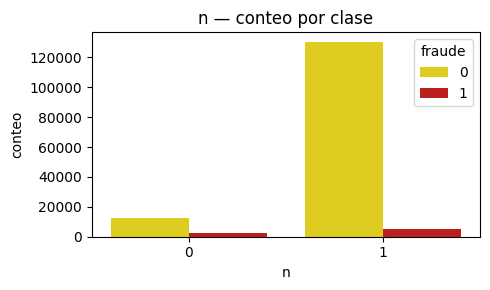

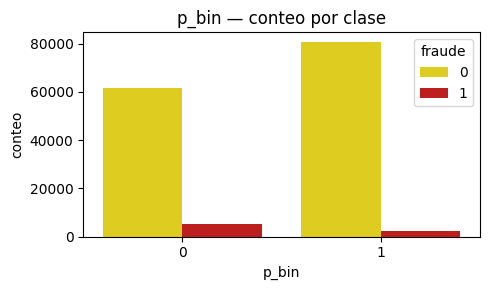

In [47]:
for col in bin_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(
        data=df,
        x=col,
        hue=TARGET,
        order=[0,1],
        hue_order=[0,1],
        palette=PALETTE
    )
    plt.title(f"{col} — conteo por clase")
    plt.xlabel(col); plt.ylabel("conteo")
    plt.tight_layout()
    plt.show()

La variable "n" puede ser una variable de la cual prescindir , ya que la mayoria de sus valores son 1 y muy pocos 0 que pueden no describir un comportamiento referente al fraude

* variables numericas

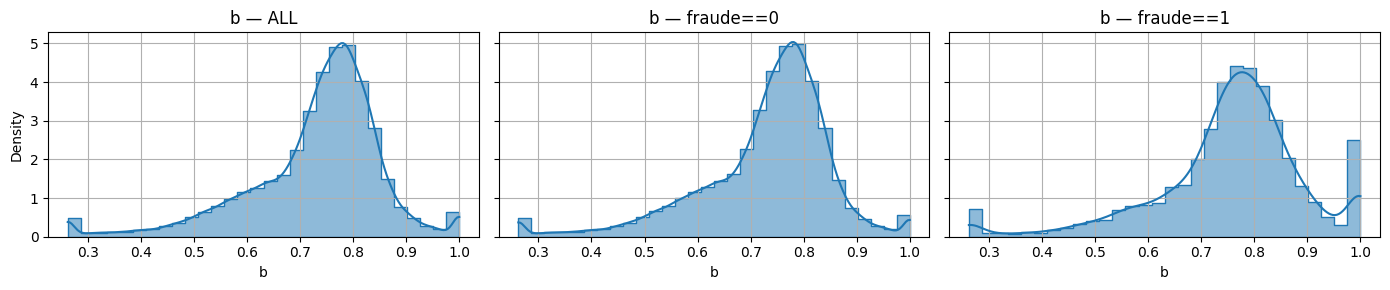

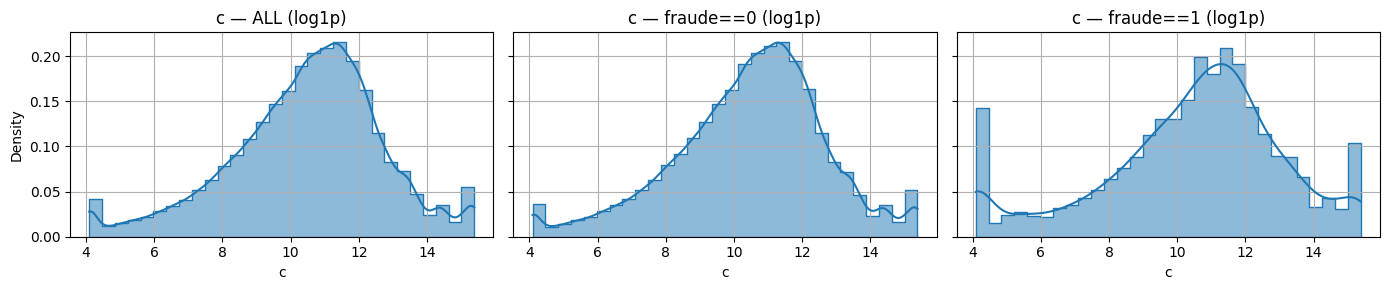

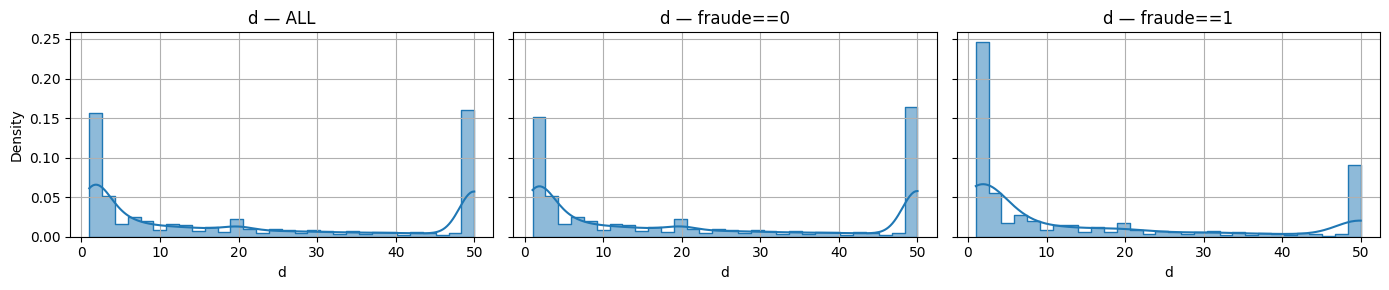

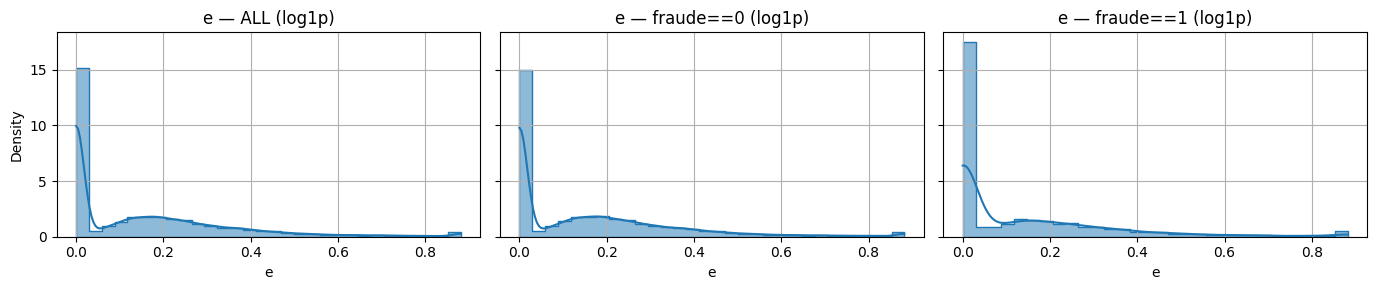

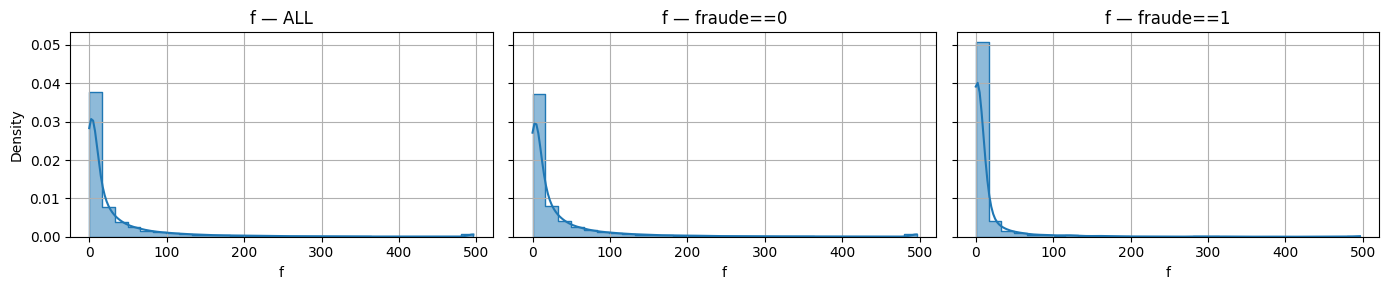

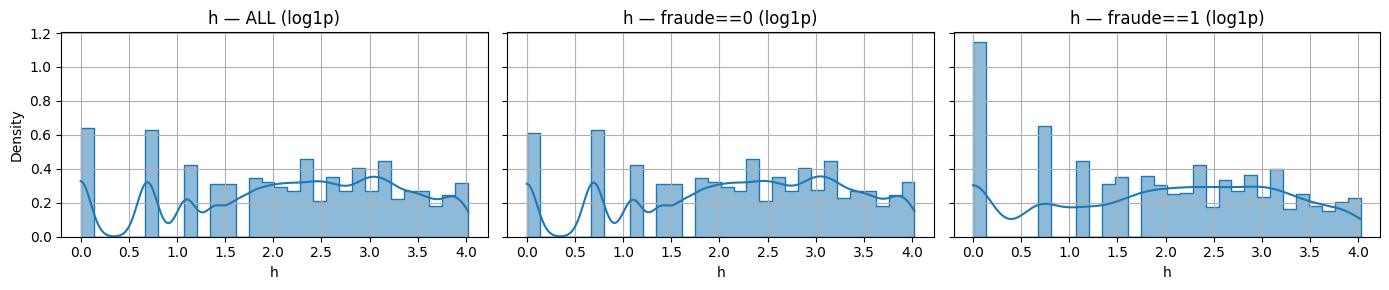

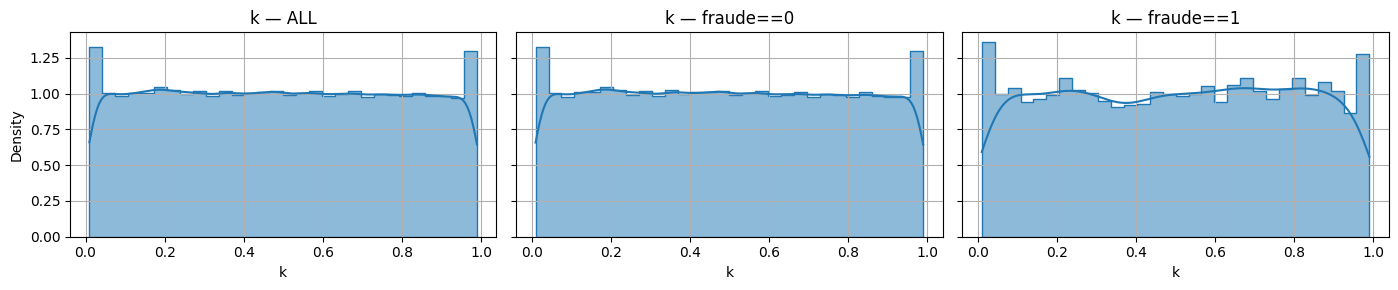

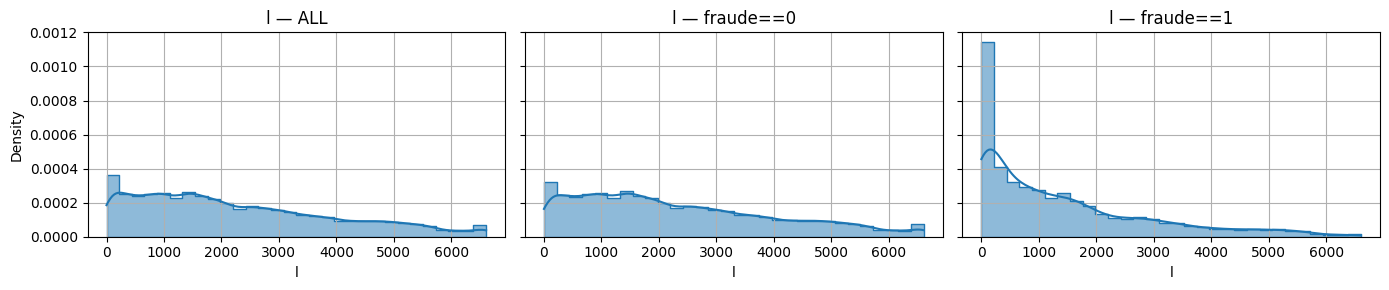

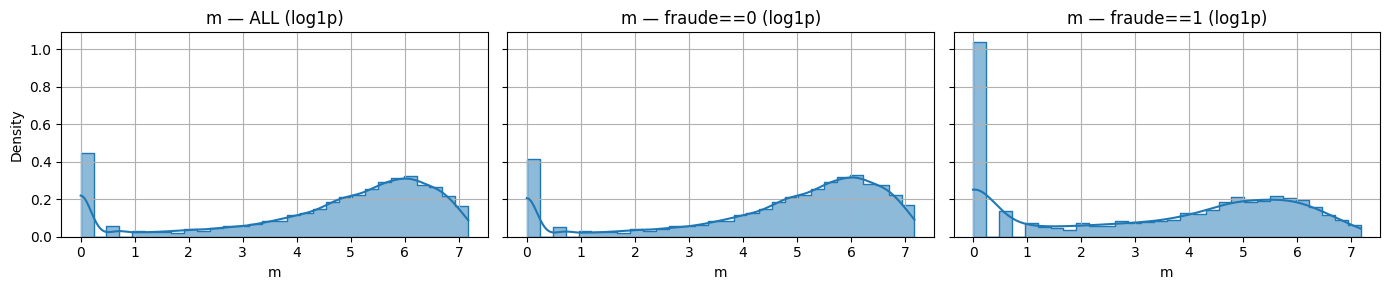

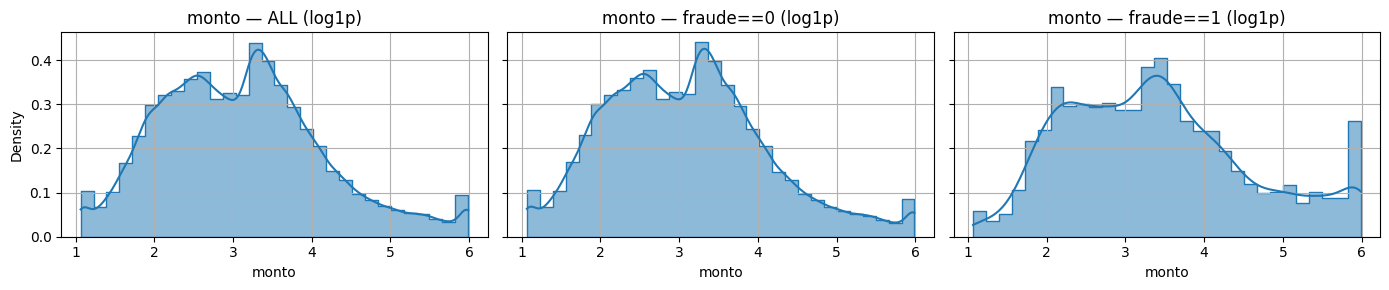

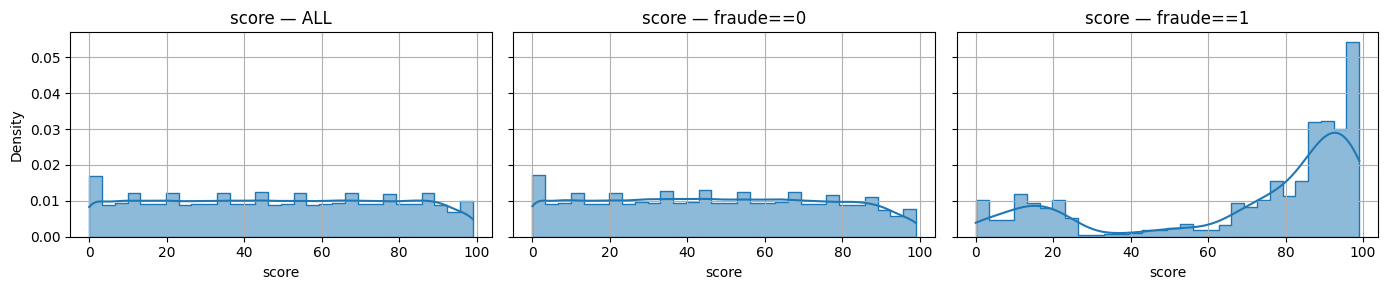

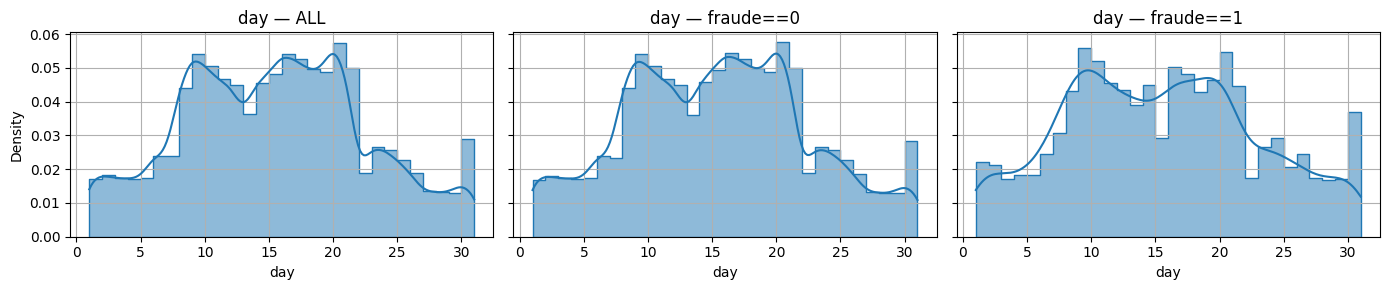

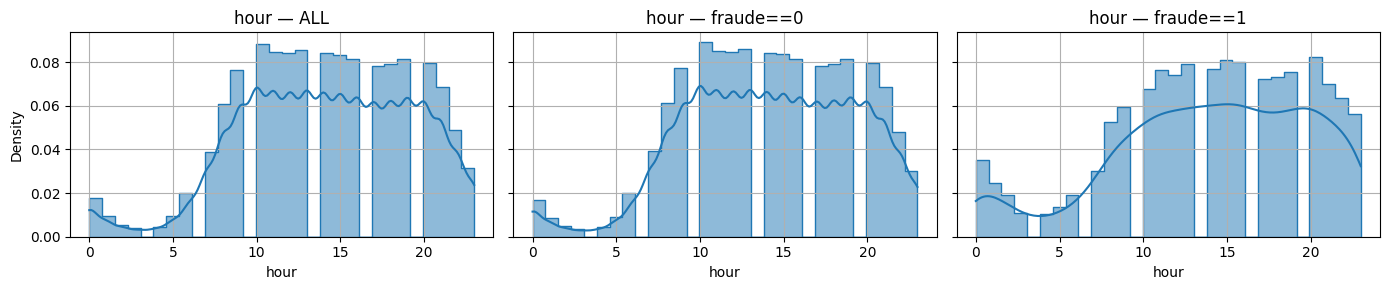

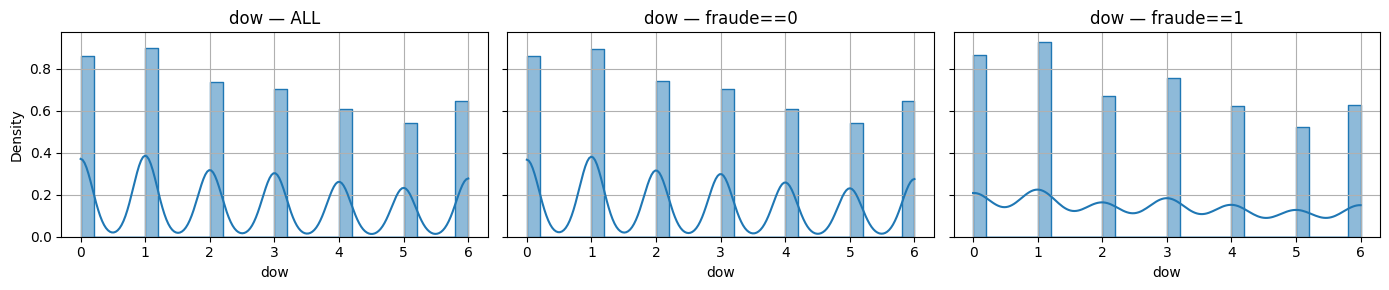

In [69]:
for col in cont_cols:
    x_all = pd.to_numeric(df[col], errors="coerce")
    x_non_fraud  = pd.to_numeric(df.loc[df[TARGET] == 0, col], errors="coerce")
    x_fraud  = pd.to_numeric(df.loc[df[TARGET] == 1, col], errors="coerce")
    use_log = x_non_fraud.min(skipna=True) >= 0 and x_non_fraud.skew(skipna=True) > 1
    if use_log:
        x_all, x_non_fraud, x_fraud = np.log1p(x_all), np.log1p(x_non_fraud), np.log1p(x_fraud)

    if x_non_fraud.notna().sum() >= 20:
        lo, hi = np.nanpercentile(x_non_fraud.dropna().values, [1, 99])
    else:
        lo, hi = float(np.nanmin(x_all)), float(np.nanmax(x_all))
        
    x_all_c       = x_all.clip(lower=lo, upper=hi).dropna()
    x_non_fraud_c = x_non_fraud.clip(lower=lo, upper=hi).dropna()
    x_fraud_c     = x_fraud.clip(lower=lo, upper=hi).dropna()

    Xs = [x_all_c, x_non_fraud_c, x_fraud_c]

    fig, ax = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
    for a, x, t in zip(ax, Xs, ["ALL", "fraude==0", "fraude==1"]):
        sns.histplot(x, bins=30, kde=True, stat="density", element="step", ax=a)
        a.set_title(f"{col} — {t}" + (" (log1p)" if use_log else ""))
        a.set_xlabel(col)
        a.grid(True)
    plt.tight_layout()
    plt.show()

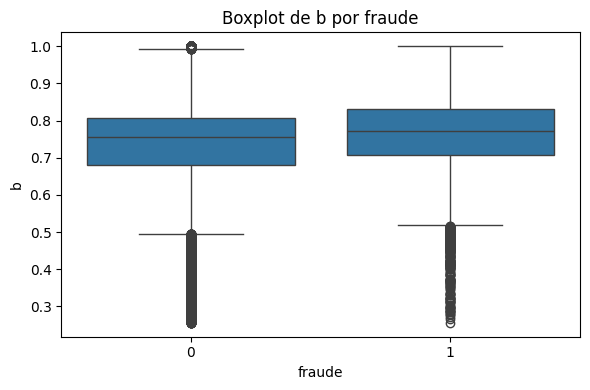

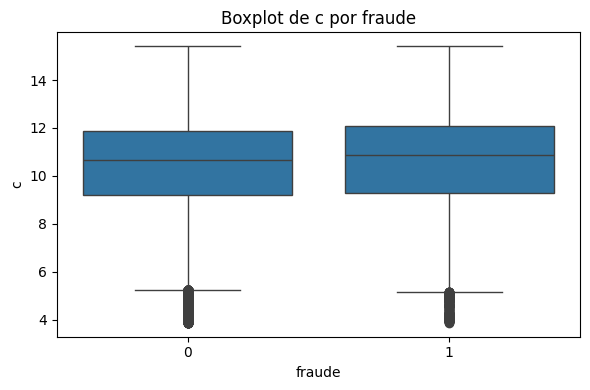

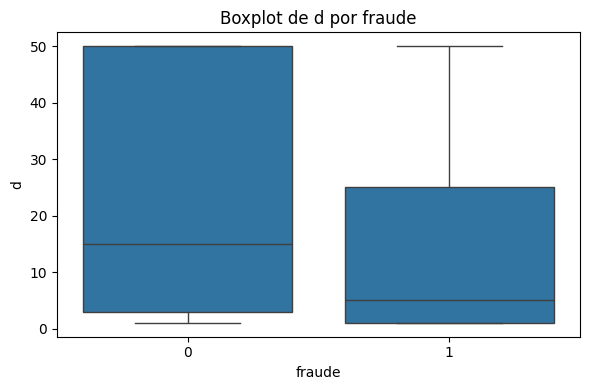

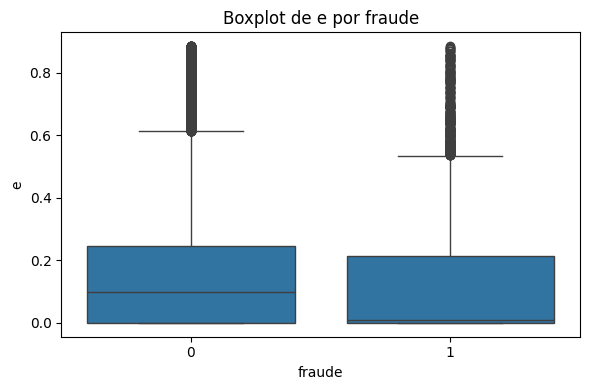

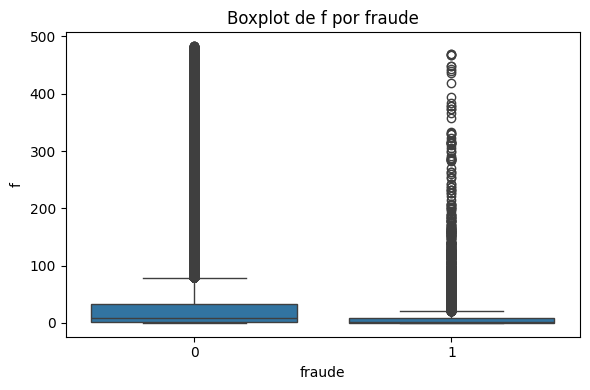

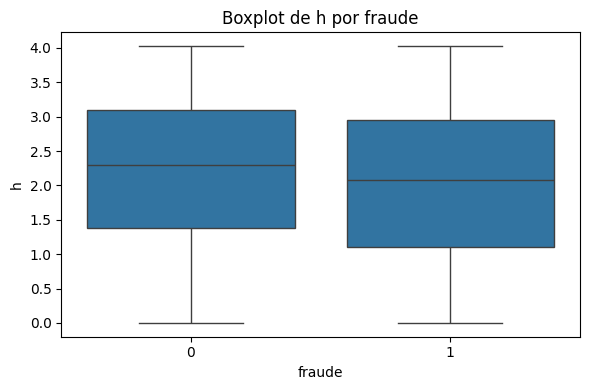

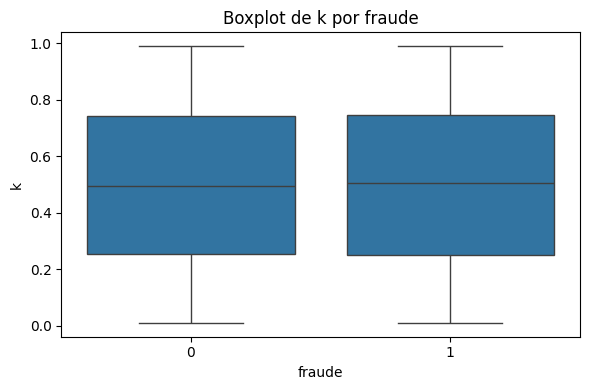

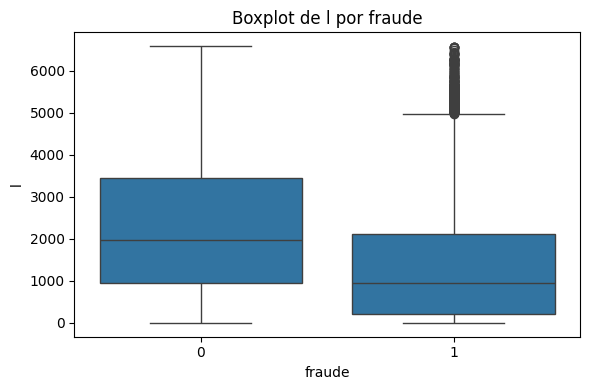

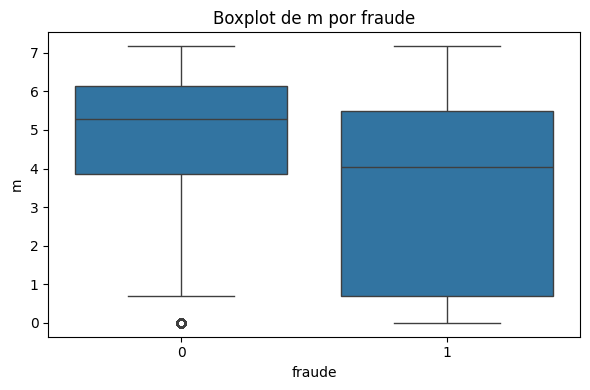

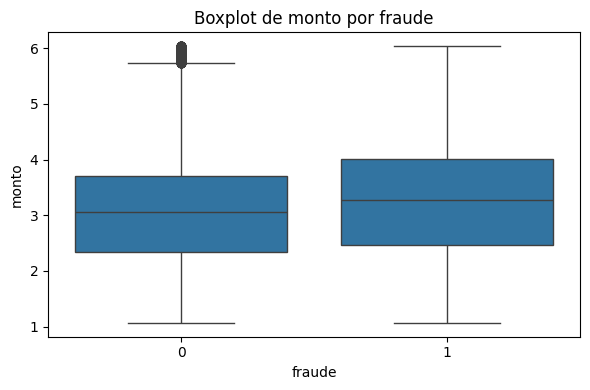

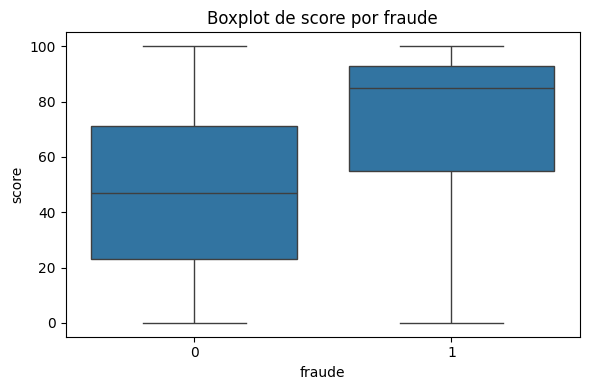

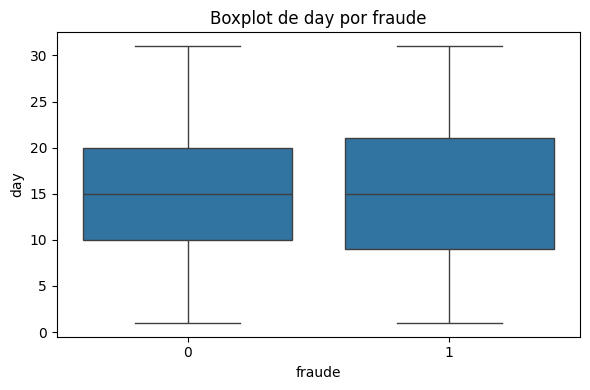

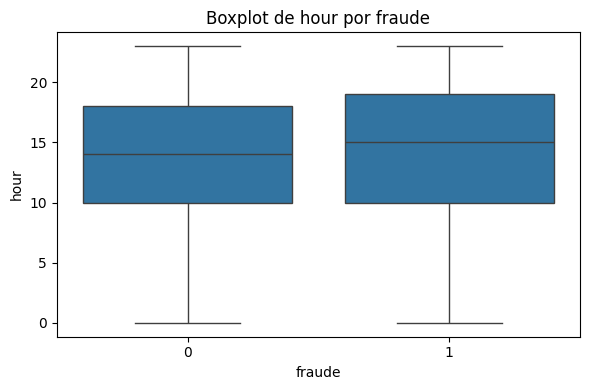

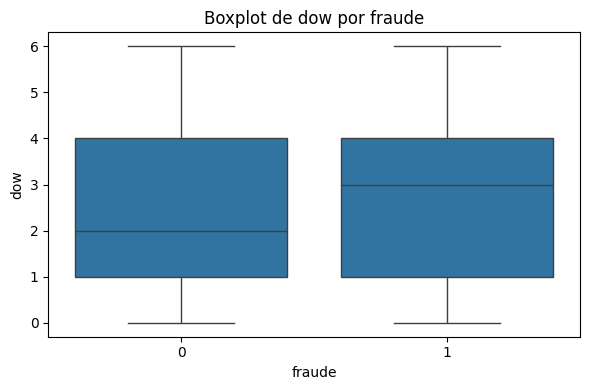

In [ ]:
for col in cont_cols:
    x_raw = pd.to_numeric(df[col], errors="coerce")
    mask = x_raw.notna()
    x = x_raw[mask].copy()

    used_log = False
    if len(x) >= 50 and x.min() >= 0 and x.skew() > 1.0:
        x = np.log1p(x)
        used_log = True

    lo, hi = np.percentile(x, [1, 99])
    keep = (x >= lo) & (x <= hi)
    x = x[keep]
    y = df.loc[x.index, TARGET] 

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=y.astype("category"), y=x)
    ttl = f"Boxplot de {col} por {TARGET}"
    plt.title(ttl)
    plt.xlabel(TARGET)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


* Distribucion variables categoricas

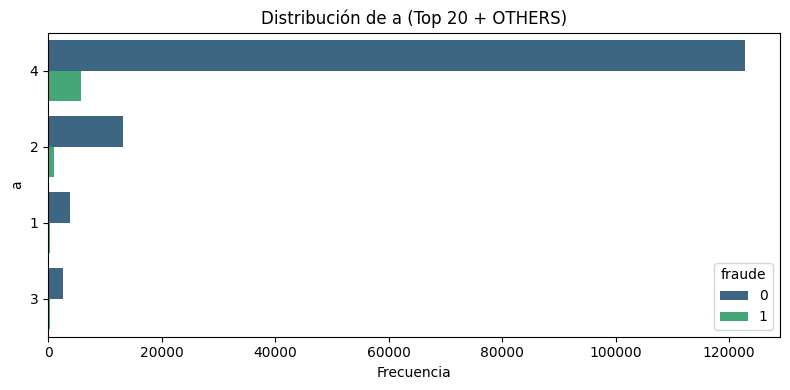

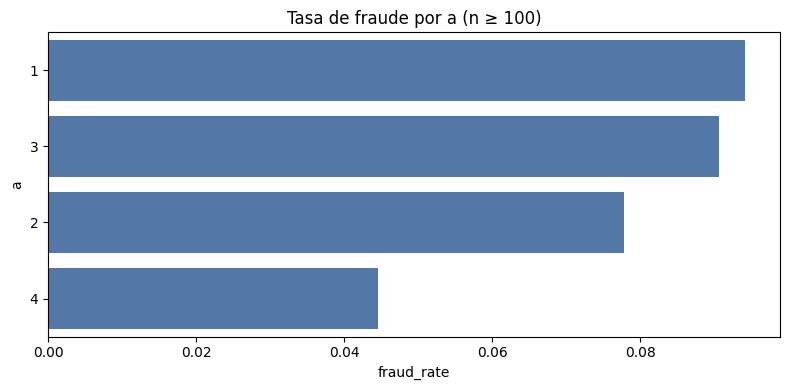

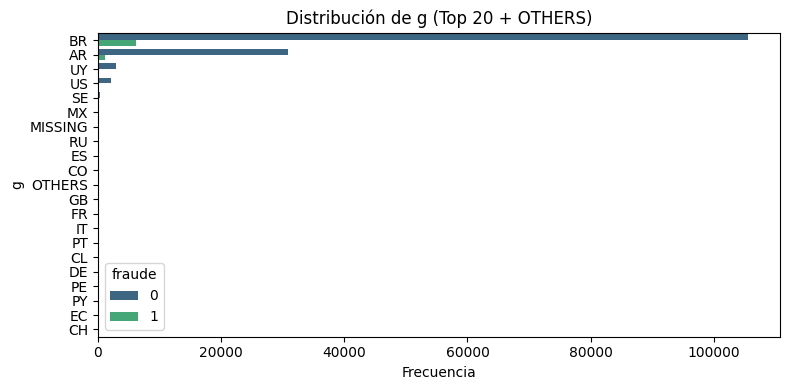

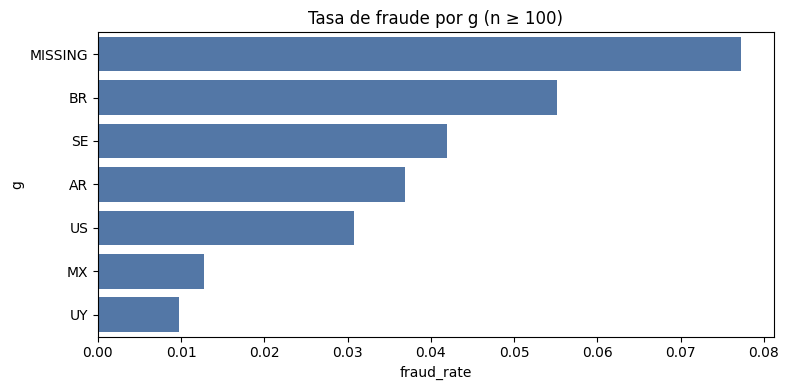

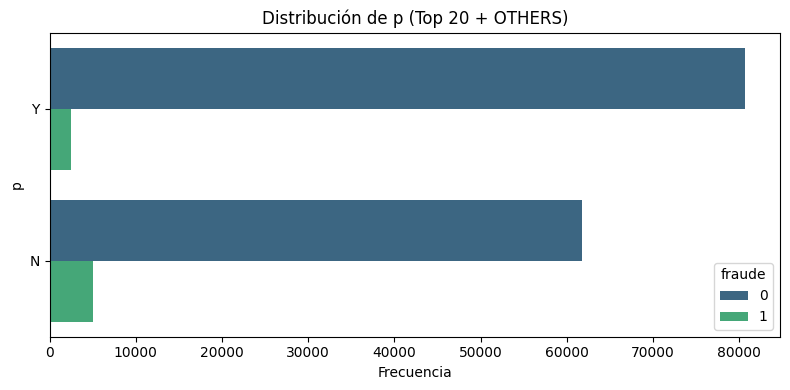

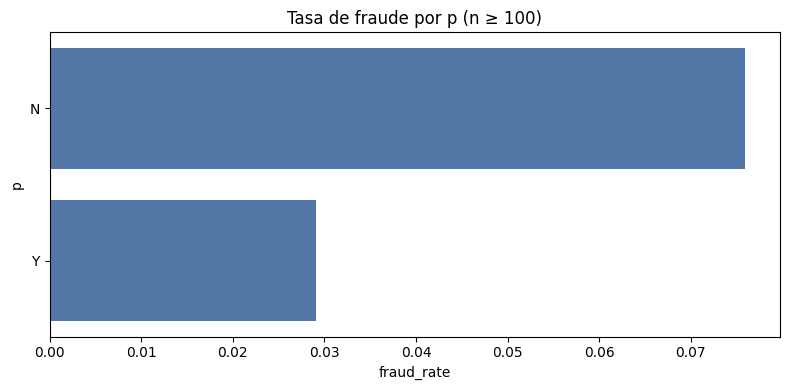

In [76]:
TOP_N  = 20
MIN_COUNT_RATE = 100   

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
skip_cols = ["j", "fecha_date", TARGET]
cat_cols = [c for c in cat_cols if c not in skip_cols]

for col in cat_cols:
    col_clean = df[col].astype("string").fillna("MISSING")
    col_value_counts = col_clean.value_counts() 
    cats = col_value_counts[col_value_counts >= MIN_COUNT_RATE].index
    top = col_value_counts.head(TOP_N).index 
    s_plot = col_clean.where(col_clean.isin(top), other="OTHERS")
    order = s_plot.value_counts().index 
    plt.figure(figsize=(8, 4))
    sns.countplot(y=s_plot, hue=df["fraude"] , order=order, palette="viridis")
    plt.title(f"Distribución de {col} (Top {TOP_N} + OTHERS)")
    plt.xlabel("Frecuencia")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
    data = (
        pd.DataFrame({col: col_clean, TARGET: df[TARGET]})
        .loc[col_clean.isin(cats)]
        .groupby(col)[TARGET]
        .mean()
        .sort_values(ascending=False)
    )
    plt.figure(figsize=(8, 4))
    sns.barplot(x=data.values, y=data.index, orient="h", color="#4575b4")
    plt.title(f"Tasa de {TARGET} por {col} (n ≥ {MIN_COUNT_RATE})")
    plt.xlabel("fraud_rate") 
    plt.ylabel(col)
    plt.tight_layout() 
    plt.show()


# Time series

In [77]:
tmp = df.groupby(['hour', 'fraude'])[AMOUNT].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df_tmp = pd.DataFrame(tmp)
df_tmp.columns = ['hour', 'fraude', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df_tmp.head()



,hour,fraude,Min,Max,Transactions,Sum,Mean,Median,Var
0,0,0,0.54,727.39,1833,66408.66,36.229493,17.820,3942.152518
1,0,1,2.07,1557.80,203,15860.97,78.132857,27.000,24202.122973
2,1,0,0.20,1063.23,928,32029.13,34.514149,16.825,5015.944742
3,1,1,1.62,660.52,142,9665.97,68.070211,26.570,12433.482327
4,2,0,0.39,465.74,528,17774.40,33.663636,18.740,2571.432054


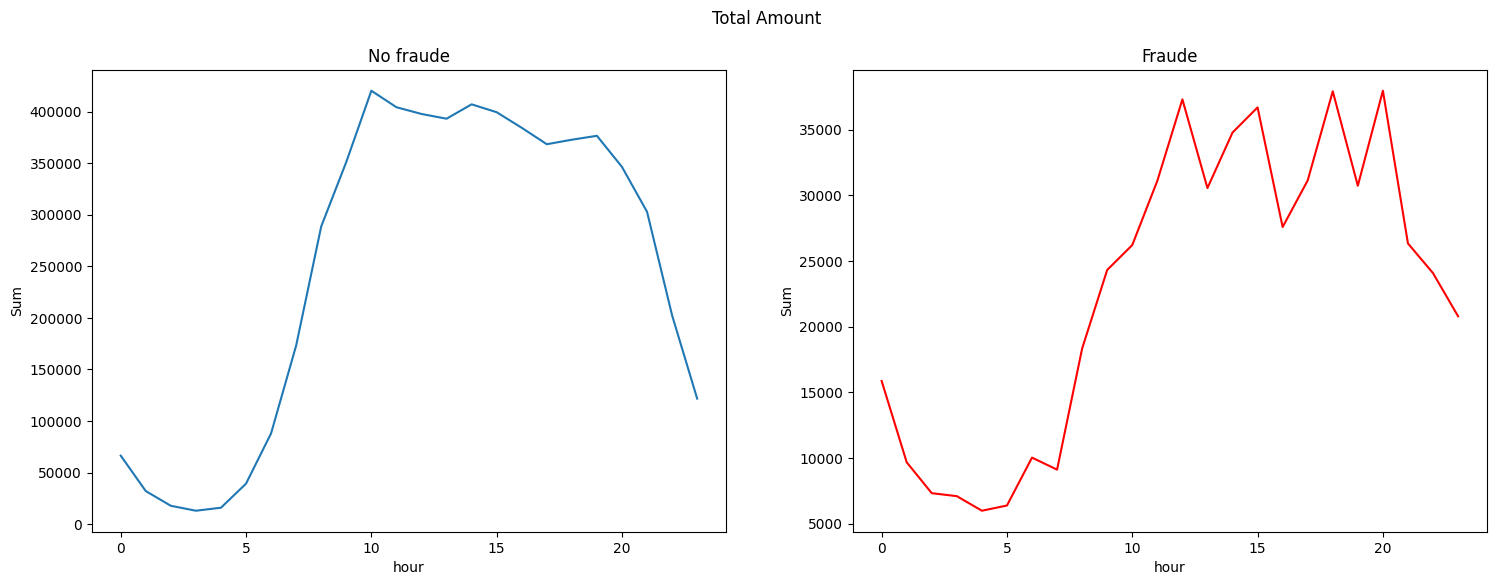

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.set_title("No fraude")
ax2.set_title("Fraude")
sns.lineplot(ax = ax1, x="hour", y="Sum", data=df_tmp.loc[df_tmp.fraude==0])
sns.lineplot(ax = ax2, x="hour", y="Sum", data=df_tmp.loc[df_tmp.fraude==1], color="red")
plt.suptitle("Total Amount")
plt.show()

- Picos anormales en fraude a altas horas de la noche
- ¿ Existe una relacion con la hora y el fraude ?

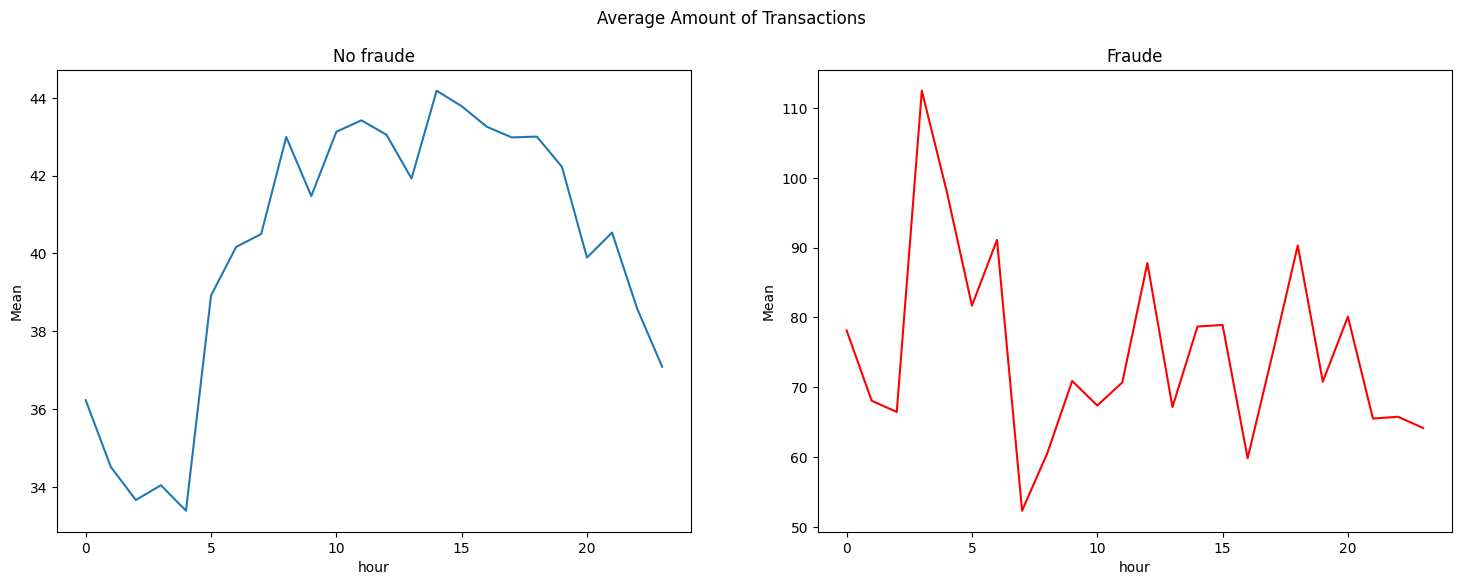

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.set_title("No fraude")
ax2.set_title("Fraude")
sns.lineplot(ax = ax1, x="hour", y="Mean", data=df_tmp.loc[df_tmp.fraude==0])
sns.lineplot(ax = ax2, x="hour", y="Mean", data=df_tmp.loc[df_tmp.fraude==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show()


- Fraude tiende a tener en promedio tickets mas altos
- Valores de tickets mas altos en la "madrugada"
- Ventanas de tiempo que tienen de 1x a 3x+ promedio de ticket
- ¿ Se refuerza la hipotesis que en horarios especificos hay mayor riesgo de fraude ?  
- ¿ El riesgo de fraude es un tema de tiempo o existe alguna estacionalidad o evento ( mensual o diario ) que aumente el riesgo ?

In [93]:
df["date"] = pd.to_datetime(df["fecha"], errors="coerce", utc=True).dt.floor("D")

daily = (df.groupby("date")
          .agg(tx_count=("fraude", "size"),
               fraude_count=("fraude", "sum"),
               amount_sum=("monto", "sum"))
          .sort_index())

daily.index.name = "date"
daily["fraud_rate"] = (daily["fraude_count"] / daily["tx_count"]).replace([np.inf, np.nan], 0.0)
daily["tx_count_7d"]   = daily["tx_count"].rolling(7, min_periods=1).mean()
daily["fraud_rate_7d"] = daily["fraud_rate"].rolling(7, min_periods=1).mean()

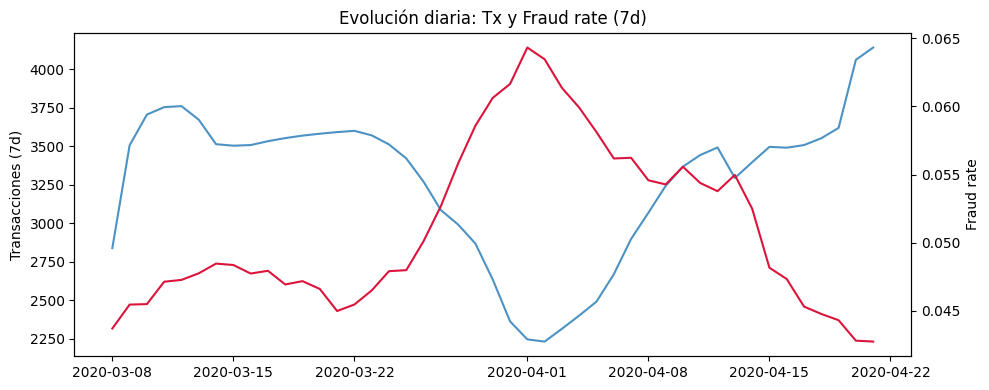

In [94]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(daily.index, daily["tx_count_7d"], label="Tx 7d", alpha=.8)
ax1.set_ylabel("Transacciones (7d)")
ax2 = ax1.twinx()
ax2.plot(daily.index, daily["fraud_rate_7d"], color="crimson", label="Fraud rate 7d")
ax2.set_ylabel("Fraud rate")
ax1.set_title("Evolución diaria: Tx y Fraud rate (7d)")
fig.tight_layout()
plt.show()


* Pico sumamente anormal en las transacciones de fraude en un rango de fechas muy especifico , adicionalemnte aumenta el nivel de fraude y baja abruptamente el nivel de transacciones 

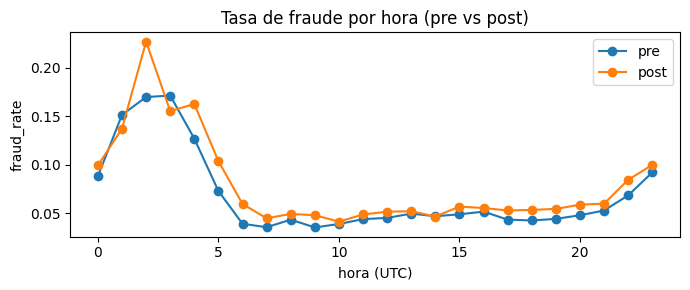

In [ ]:
d = df.copy()
d["date"] = pd.to_datetime(d[TIME], utc=True).dt.floor("D")

daily = (d.groupby("date")[TARGET]
          .agg(n="size", k="sum", rate="mean")
          .reset_index()
          .sort_values("date"))
daily["rate_7d"] = daily["rate"].rolling(7, min_periods=3).mean()
daily["delta"]   = daily["rate_7d"].diff()

t_change = daily.loc[daily["delta"].idxmax(), "date"]

pre  = daily[(daily["date"]>=t_change-pd.Timedelta(days=14)) & (daily["date"]<t_change)]
post = daily[(daily["date"]>=t_change) & (daily["date"]<t_change+pd.Timedelta(days=14))]
d["hour"] = pd.to_datetime(d[TIME], utc=True).dt.hour
pre_mask  = (d["date"]>=t_change-pd.Timedelta(days=14)) & (d["date"]<t_change)
post_mask = (d["date"]>=t_change) & (d["date"]<t_change+pd.Timedelta(days=14))

hour_pre  = d.loc[pre_mask].groupby("hour")[TARGET].mean()
hour_post = d.loc[post_mask].groupby("hour")[TARGET].mean()

plt.figure(figsize=(7,3))
plt.plot(hour_pre.index, hour_pre.values, label="pre", marker="o")
plt.plot(hour_post.index, hour_post.values, label="post", marker="o")
plt.title("Tasa de fraude por hora (pre vs post)")
plt.xlabel("hora (UTC)")
plt.ylabel("fraud_rate")
plt.legend()
plt.tight_layout()
plt.show()


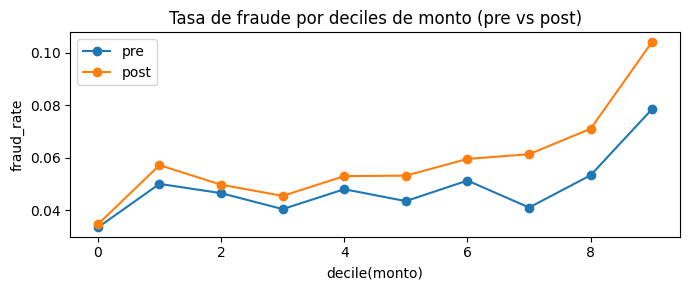

In [ ]:
d["monto_dec"] = pd.qcut(d["monto"].rank(method="first"), 10, labels=False, duplicates="drop")
m_pre  = d.loc[pre_mask].groupby("monto_dec")[TARGET].mean()
m_post = d.loc[post_mask].groupby("monto_dec")[TARGET].mean()

plt.figure(figsize=(7,3))
plt.plot(m_pre.index,  m_pre.values,  label="pre",  marker="o")
plt.plot(m_post.index, m_post.values, label="post", marker="o")
plt.title("Tasa de fraude por deciles de monto (pre vs post)")
plt.xlabel("decile(monto)")
plt.ylabel("fraud_rate")
plt.legend()
plt.tight_layout()
plt.show()


- Usando ventanas temporales se puede afirmar que en efecto existen horarios , fechas y montos en los cuales el riesgo de fraude aumenta , esto atado al hecho de que las ventanas temporales se formaron apartir de un fecha en especifico la cual es que tuvo un delta mas alto dia a dia. 
- Hallazgos:
  - Montos (deciles) – “pre vs post”:
    * El riesgo crece casi monótonamente con el monto.
    * Desde el decil 6 la curva se empina; en post es sistemáticamente mayor que en pre.
    * En el decil 9 la tasa sube con fuerza (post - 10% vs pre - 7 – 8%) - Señal clara para una feature/umbral de “monto alto”.
  - Horario (UTC) – “pre vs post”:
    * Pico alrededor de 2–3 h (pre - 17%, post - 22%).
    * Hacia la noche (22–23 h) vuelve a subir (post 9 - 10%).
    * En casi todas las horas, post > pre , Incluir hour/night y contemplar umbrales por franja.
  - Evolución diaria (7d):
    * A partir de 2020-03-28 la tasa acelera (máx. cambio) hasta inicios de abril y luego cede; en paralelo el volumen cae. Indicio de cambio de régimen / campaña puntual.

# Matriz de coorelacion

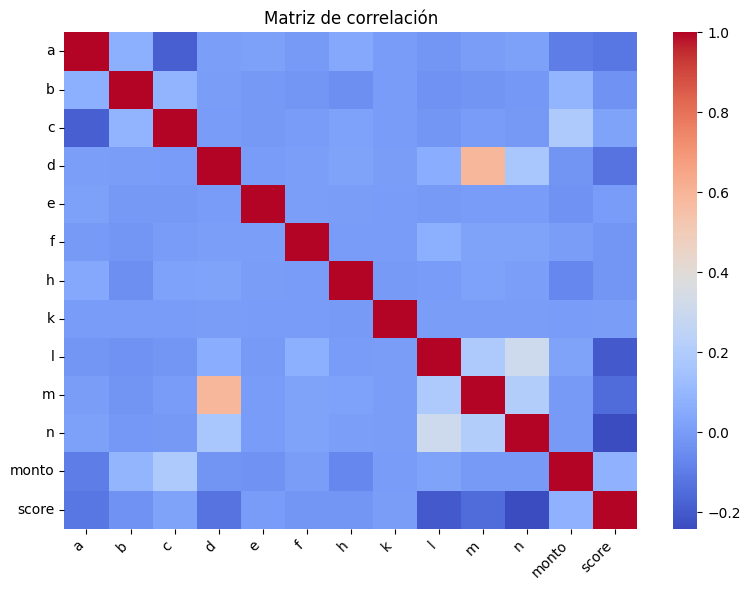

In [132]:
num = df.select_dtypes(include=[np.number]).drop(columns=[TARGET], errors="ignore")
plt.figure(figsize=(8, 6))
sns.heatmap(
    num.corr(), cmap="coolwarm"
)
plt.title("Matriz de correlación")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9331/2354843365.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette="coolwarm")


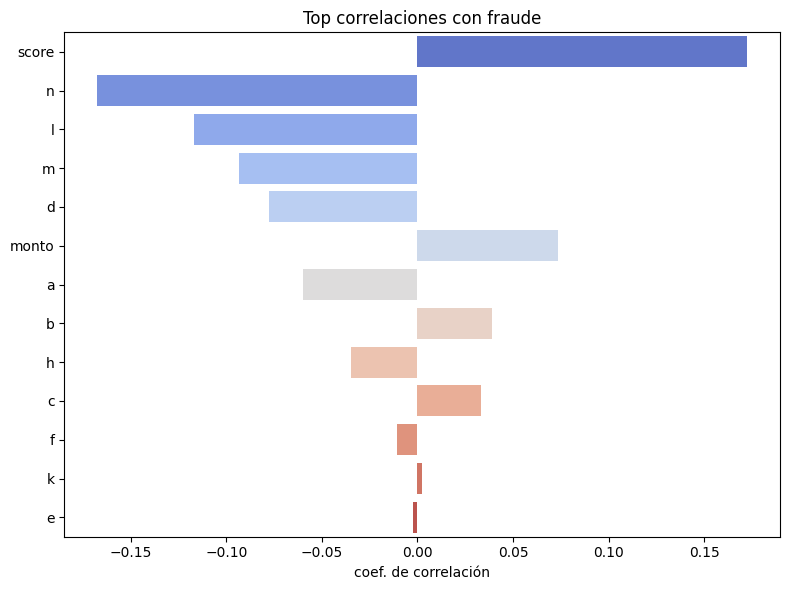

In [135]:
num_t = df.select_dtypes(include=[np.number]).copy()
tcorr = num_t.corr()[TARGET].drop(TARGET)
top = tcorr.reindex(tcorr.abs().sort_values(ascending=False).head(15).index)

plt.figure(figsize=(8, 6))
sns.barplot(x=top.values, y=top.index, palette="coolwarm")
plt.title(f"Top correlaciones con {TARGET}")
plt.xlabel("coef. de correlación")
plt.ylabel("")
plt.tight_layout()
plt.show()


## Balance de clases : variable objetivo

/tmp/ipykernel_101863/978997596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[TARGET], palette="coolwarm")


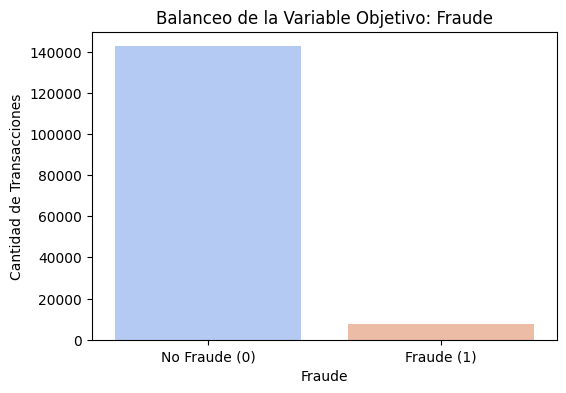

Distribución de fraudes en %:
 fraude
0    95.0
1     5.0
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df[TARGET], palette="coolwarm")
plt.xticks(ticks=[0,1], labels=["No Fraude (0)", "Fraude (1)"], rotation=0)
plt.xlabel("Fraude")
plt.ylabel("Cantidad de Transacciones")
plt.title("Balanceo de la Variable Objetivo: Fraude")
plt.show()

sales_counts = df[TARGET].value_counts(normalize=True) * 100
print("Distribución de fraudes en %:\n", sales_counts)


La distribucion de la variable objetivo muestra un muy alto desbalance , lo cual afectara el proceso de aprendizaje para esto se tienen algunas opciones como Sub sampling , Over sampling , ajuste umbral de decision , etc ...

# Modelado

  ### PIPELINE

In [136]:
def create_pipeline(numeric_cols: list, categorical_cols: list, columns_to_drop: list) -> Pipeline:
    """
    Create a scikit-learn pipeline for data preprocessing and feature engineering.

    Args:
        numeric_cols : list
        categorical_cols : list
        columns_to_drop : list

    Returns:
        pipeline
    """


    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ])

    preprocessing = ColumnTransformer(
        transformers=[
            ("num", num_pipeline, numeric_cols),
            ("cat", cat_pipeline, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.0,
    )


    pipeline = Pipeline([
        ('feature_engineering',  FeatureEnginnering()),
        ("column_dropper", ColumnDropper(columns=columns_to_drop)),
        ('preprocessing', preprocessing)
    ])

    return pipeline

### SPLITTER

In [137]:
def create_train_test_splitter(X : pd.DataFrame, y : pd.Series):
    """
    Create a train-test split for the dataset.

    Returns:
        X_train: train features
        X_test: test features
        y_train: train labels
        y_test: test labels
        X_val: validation features
        y_val: validation labels
    """
    
    test_size = 0.15
    val_size = 0.15
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y,
        test_size=(test_size + val_size),
        random_state=RANDOM_STATE,
        stratify=y,
    )

    rel_test = test_size / (test_size + val_size)
    X_test, X_val, y_test, y_val = train_test_split(
        X_tmp, y_tmp,
        test_size=rel_test,
        random_state=RANDOM_STATE,
        stratify=y_tmp,
    )

    return X_train, X_test, y_train, y_test, X_val, y_val

### HELPERS Y METRICAS

In [138]:
def gains_by_threshold(
    y_true: np.ndarray, proba: np.ndarray, amounts: np.ndarray,
    threshold: float, margin: float = 0.25, loss: float = 1.0
):
    """
    Rule: accept if proba < threshold.
      - Accept non fraud : + margin * amount
      - Accept fraud : - loss * amount
    """
    accept = proba < threshold
    non_fraud   = (y_true == 0)
    fraud   = (y_true == 1)

    gain_non_fraud = (accept & non_fraud) * (margin * amounts)
    loss_fraud = (accept & fraud) * (loss   * amounts)
    return (gain_non_fraud.sum() - loss_fraud.sum())

In [139]:
def threshold_seeker(
    y_true: np.ndarray, proba: np.ndarray, amounts: np.ndarray,
    margin: float = 0.25, loss: float = 1.0, grid: int = 101
):
    """
      Search the best threshold and returns the threshold and the gains perceived

    Returns:
        best_threshold: best probability threshold
        gain_in_best_treshold: nominal value of the gain perceived at the threshold
    """
    
    values  = np.linspace(0, 1, grid)
    thresholds = np.quantile(proba, values)
    best_thr, best_profit = 0.5, -np.inf
    for threshold in thresholds:
        profit = gains_by_threshold(y_true, proba, amounts, threshold, margin, loss)
        if profit > best_profit:
            best_profit, best_thr = profit, threshold
    return best_thr, best_profit

In [140]:
def confusion_matrix_by_threshold(y_true: np.ndarray, proba: np.ndarray, threshold: float):

    pred = (proba >= threshold).astype(int)
    tp = int(((pred == 1) & (y_true == 1)).sum())
    fp = int(((pred == 1) & (y_true == 0)).sum())
    tn = int(((pred == 0) & (y_true == 0)).sum())
    fn = int(((pred == 0) & (y_true == 1)).sum())
    return {"TP": tp, "FP": fp, "TN": tn, "FN": fn}

In [ ]:
def cross_validate_model(
    X,
    y,
    amounts,  
    preprocessor: Pipeline,
    estimator,
    n_splits: int = 5,
    random_state: int = 42,
):
    y = np.asarray(y)
    amt = np.asarray(amounts) 
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oos = np.zeros(len(y), dtype=float)
    rows = []

    for k, (tr, va) in enumerate(skf.split(X, y), 1):
        pipe = Pipeline([("prep", preprocessor), ("clf", estimator)])
        X_train, X_val = X.iloc[tr], X.iloc[va]
        y_train, y_val = y[tr], y[va]
        amount_train, amount_val = amt[tr], amt[va]

        pipe.fit(X_train, y_train)

        probs_train = pipe.predict_proba(X_train)[:, 1]
        probs_va = pipe.predict_proba(X_val)[:, 1]
        oos[va] = probs_va

        auc_train = roc_auc_score(y_train, probs_train)
        ap_tr = average_precision_score(y_train, probs_train)
        auc_val = roc_auc_score(y_val, probs_va)
        ap_va = average_precision_score(y_val, probs_va)

        threshold_val, prof_va = threshold_seeker(y_val, probs_va, amount_val, margin=0.25, loss=1.0)
        cm_val = confusion_matrix_by_threshold(y_val, probs_va, threshold_val)
        gains_train = gains_by_threshold(y_train, probs_train, amount_train, threshold=threshold_val, margin=0.25, loss=1.0)

        rows.append({
            "fold": k,
            "auc_train": float(auc_train), "ap_train": float(ap_tr),
            "auc_valid": float(auc_val), "ap_valid": float(ap_va),
            "threshold_valid": float(threshold_val),
            "gains_train_in_thr_valid": float(gains_train),
            "gains_valid": float(prof_va),
            "cm_valid": cm_val,
        })

    auc_oos = roc_auc_score(y, oos)
    ap_oos  = average_precision_score(y, oos)
    threshold_oos, gains_oos = threshold_seeker(y, oos, amt, margin=0.25, loss=1.0)
    cm_oos = confusion_matrix_by_threshold(y, oos, threshold_oos)

    folds_metrics = pd.DataFrame(rows, columns=[
        "fold","auc_train","auc_valid","ap_train","ap_valid",
        "threshold_valid","gains_train_in_thr_valid","gains_valid"
    ])

    return {
        "oos_proba": oos,
        "summary": {
            "roc_auc": float(auc_oos),
            "ap": float(ap_oos),
            "threshold": float(threshold_oos),
            "gains": float(gains_oos),
            "cm": cm_oos,
        },
        "folds": rows,
        "folds_metrics": folds_metrics,
    }

In [142]:
def search_best_params(
    model_type: str,
    X: pd.DataFrame, y: np.ndarray,
    preprocessor: Pipeline,
    n_trials: int = 80,
) -> Pipeline:
    
    """
    Optuna hyperparameters trainer for 3 models : XGB , RF , LR
    """
    def objective(trial):
        if model_type.upper() == "XGB":
            params = {
                "n_estimators":      trial.suggest_int("n_estimators", 100, 500),
                "max_depth":         trial.suggest_int("max_depth", 3, 10),
                "learning_rate":     trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
                "subsample":         trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "gamma":             trial.suggest_float("gamma", 0.0, 5.0),
                "min_child_weight":  trial.suggest_float("min_child_weight", 1.0, 10.0),
                "reg_lambda":        trial.suggest_float("reg_lambda", 0.0, 5.0),
                "n_jobs": -1,
                "random_state": RANDOM_STATE,
                "eval_metric": "auc",
                "use_label_encoder": False,
            }
            est = XGBClassifier(**params)

        elif model_type.upper() == "RF":
            params = {
                "n_estimators":     trial.suggest_int("n_estimators", 200, 800),
                "max_depth":        trial.suggest_int("max_depth", 4, 20),
                "min_samples_split":trial.suggest_int("min_samples_split", 2, 10),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
                "max_features":     trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
                "random_state":     RANDOM_STATE,
                "n_jobs": -1,
                "class_weight": "balanced", 
            }
            est = RandomForestClassifier(**params)

        else: 
            params = {
                "C":        trial.suggest_float("C", 0.05, 10.0, log=True),
                "max_iter": trial.suggest_int("max_iter", 200, 1000),
                "penalty":  trial.suggest_categorical("penalty", ["l2"]),
                "solver":   trial.suggest_categorical("solver", ["lbfgs", "liblinear"]),
                "class_weight": "balanced",
                "random_state": RANDOM_STATE,
            }
            est = LogisticRegression(**params)

        pipe = Pipeline([("prep", preprocessor), ("clf", est)])
        scores = cross_val_score(pipe, X, y, scoring="roc_auc", cv=3, n_jobs=-1)
        return float(np.mean(scores))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    if model_type.upper() == "XGB":
        best = XGBClassifier(**best_params, n_jobs=-1, random_state=RANDOM_STATE,
                            eval_metric="auc", use_label_encoder=False)
    elif model_type.upper() == "RF":
        best = RandomForestClassifier(**best_params, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced")
    else:
        best = LogisticRegression(**best_params)

    final_model = Pipeline([("prep", preprocessor), ("clf", best)])
    final_model.fit(X, y)

    joblib.dump(final_model, f"best_model_{model_type.upper()}.pkl")
    return final_model

# TRAINNING

In [143]:
NUM_COLS = ["score" , "monto" , "night", "high_score","high_amount", "n", "l", "m", "d"]  
CAT_COLS = ["p_bin"]
DROP_COLS = [TIME]

# Preprocesador
pipe = create_pipeline(NUM_COLS, CAT_COLS, DROP_COLS)

# Split
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int).values
amounts = df["monto"].values

X_train, X_test, y_train, y_test, X_val, y_val = create_train_test_splitter(X, y)

model_xgb = search_best_params("XGB", X_train, y_train, preprocessor=pipe, n_trials=80)
model_rf  = search_best_params("RF",  X_train, y_train, preprocessor=pipe, n_trials=80)
model_lr  = search_best_params("LR",  X_train, y_train, preprocessor=pipe, n_trials=80)

res_xgb = cross_validate_model(X_train, y_train, df.loc[X_train.index, "monto"].values, pipe, model_xgb.named_steps["clf"])
res_rf  = cross_validate_model(X_train, y_train, df.loc[X_train.index, "monto"].values, pipe, model_rf.named_steps["clf"])
res_lr  = cross_validate_model(X_train, y_train, df.loc[X_train.index, "monto"].values, pipe, model_lr.named_steps["clf"])

print("XGB:", res_xgb)
print("RF :", res_rf)
print("LR :", res_lr)


[I 2025-08-13 13:27:31,489] A new study created in memory with name: no-name-300809c0-04d0-4d85-ad14-8a75056e5193
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/ds-projects-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:27:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/ds-projects-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:27:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/ds-projects-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:27:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-08-13 13:27:33,787] Trial 0 finished with

XGB: {'oos_proba': array([0.02437545, 0.00655731, 0.04273409, ..., 0.05668546, 0.03530606,
       0.01006401]), 'summary': {'roc_auc': 0.8260143463420455, 'ap': 0.30949933431050664, 'threshold': 0.19885473400354392, 'gains': 761757.1075000003, 'cm': {'TP': 1861, 'FP': 3389, 'TN': 96361, 'FN': 3389}}, 'folds': [{'fold': 1, 'auc_train': 0.852818858157298, 'ap_train': 0.3776480446058868, 'auc_valid': 0.822612030075188, 'ap_valid': 0.30082876665715325, 'threshold_valid': 0.14760309025645255, 'gains_train_in_thr_valid': 629234.6474999998, 'gains_valid': 154236.38999999996, 'cm_valid': {'TP': 442, 'FP': 1028, 'TN': 18922, 'FN': 608}}, {'fold': 2, 'auc_train': 0.8505231710227951, 'ap_train': 0.3712029064953859, 'auc_valid': 0.8299522138680033, 'ap_valid': 0.3279872894596466, 'threshold_valid': 0.2315895915031434, 'gains_train_in_thr_valid': 633001.2775, 'gains_valid': 150012.50250000003, 'cm_valid': {'TP': 345, 'FP': 495, 'TN': 19455, 'FN': 705}}, {'fold': 3, 'auc_train': 0.8517208094641365, 

In [147]:
res_xgb["folds_metrics"]

,fold,auc_train,auc_valid,ap_train,ap_valid,threshold_valid,gains_train_in_thr_valid,gains_valid
0,1,0.852819,0.822612,0.377648,0.300829,0.147603,629234.6475,154236.3900
1,2,0.850523,0.829952,0.371203,0.327987,0.231590,633001.2775,150012.5025
2,3,0.851721,0.824137,0.375494,0.304815,0.237193,619310.8550,161867.3175
3,4,0.854386,0.821272,0.377275,0.299323,0.196747,632227.3150,149281.6025
4,5,0.849294,0.833020,0.368919,0.320054,0.172979,626934.5225,154068.5000


In [148]:
res_rf["folds_metrics"]

,fold,auc_train,auc_valid,ap_train,ap_valid,threshold_valid,gains_train_in_thr_valid,gains_valid
0,1,0.856880,0.814951,0.347912,0.276665,0.670600,630427.5025,150330.9225
1,2,0.855068,0.824645,0.343844,0.309442,0.707701,637877.5950,148363.6150
2,3,0.856211,0.816068,0.346685,0.269891,0.716845,621658.0425,155633.0325
3,4,0.855689,0.818486,0.350205,0.283219,0.663707,630607.7450,148975.5575
4,5,0.854447,0.825726,0.340538,0.296030,0.744402,623031.5800,153494.7150


In [149]:
res_lr["folds_metrics"]

,fold,auc_train,auc_valid,ap_train,ap_valid,threshold_valid,gains_train_in_thr_valid,gains_valid
0,1,0.772116,0.766592,0.240743,0.229849,0.152071,595221.095,148907.1850
1,2,0.769044,0.779002,0.235326,0.252642,0.187558,593098.565,155858.7975
2,3,0.772564,0.765644,0.238934,0.231506,0.195715,595791.950,152586.8800
3,4,0.772761,0.763909,0.239901,0.233415,0.319441,591457.445,145194.3650
4,5,0.768804,0.778762,0.236265,0.247780,0.214311,597915.530,152101.3625


In [121]:
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([y_train, y_val])

models = [model_xgb, model_lr , model_rf]
for model , idx  in zip(models, range(len(models))):
  name = None
  if idx == 0 :
    name = "XGB"
  elif idx == 1:
    name = "Logistic regresion"
  else:
    name = "Random Forest"
  
  print("========================")
  print(f"Model name : {name}")
  print("========================")
  
  model.fit(X_trval, y_trval)
  proba_val = model.predict_proba(X_val)[:, 1]
  amount_val   = df.loc[X_val.index, "monto"].values
  threshold_val, gains_val = threshold_seeker(y_val, proba_val, amount_val, margin=0.25, loss=1.0)
  print(f"Treshold valid : {threshold_val} | Gains (valid) = {gains_val}")
  print(f"Gains (valid) : {gains_val}")

  proba_test = model.predict_proba(X_test)[:, 1]
  amount_test   = df.loc[X_test.index, "monto"].values

  gains_test = gains_by_threshold(y_test, proba_test, amount_test, threshold=threshold_val, margin=0.25, loss=1.0)
  print(f"Gains (test) : {gains_test}")

  cm_test = confusion_matrix_by_threshold(y_test, proba_test, threshold=threshold_val)
  print(cm_test)

Model name : XGB


/home/juliandev/Desktop/PROJECTS/DataScienceProjects/personal/ds-projects-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:26:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Treshold valid : 0.7974555206298833 | Gains (valid) = 166796.1525
Gains (valid) : 166796.1525
Gains (test) : 165406.8125
{'TP': 449, 'FP': 923, 'TN': 20452, 'FN': 676}
Model name : Logistic regresion
Treshold valid : 0.1874199312703333 | Gains (valid) = 161508.94250000003
Gains (valid) : 161508.94250000003
Gains (test) : 159832.025
{'TP': 354, 'FP': 818, 'TN': 20557, 'FN': 771}
Model name : Random Forest
Treshold valid : 0.7186146954997688 | Gains (valid) = 167351.08249999996
Gains (valid) : 167351.08249999996
Gains (test) : 161695.1825
{'TP': 501, 'FP': 1347, 'TN': 20028, 'FN': 624}


# SHAP VALUES

In [51]:
model = joblib.load("best_model_XGB.pkl")

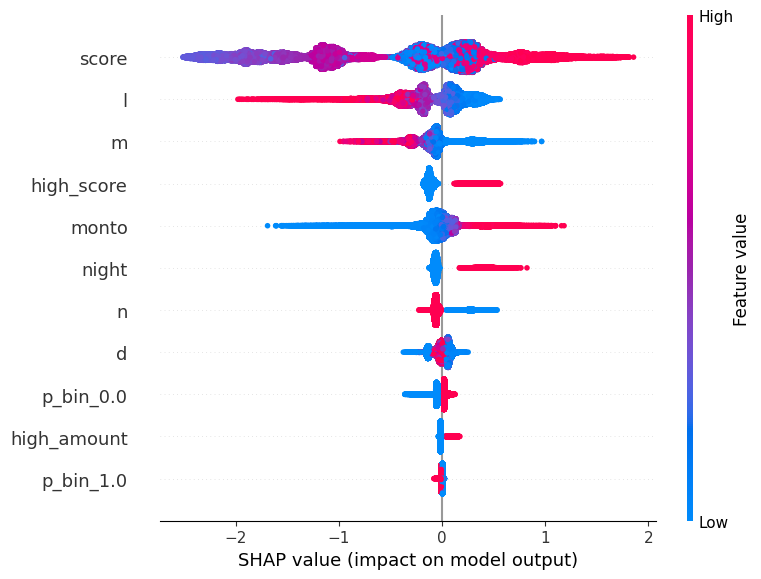

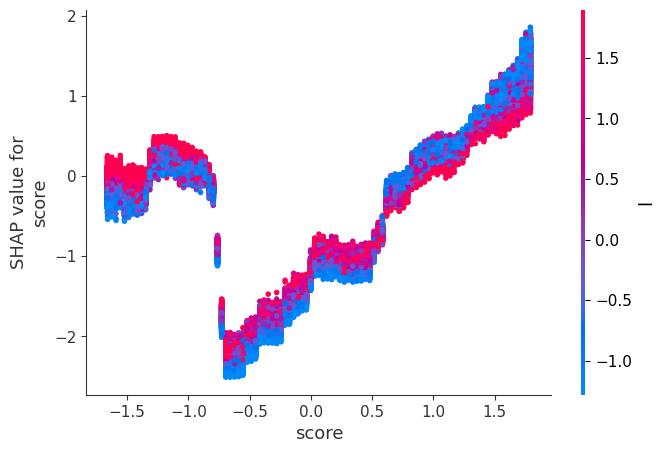

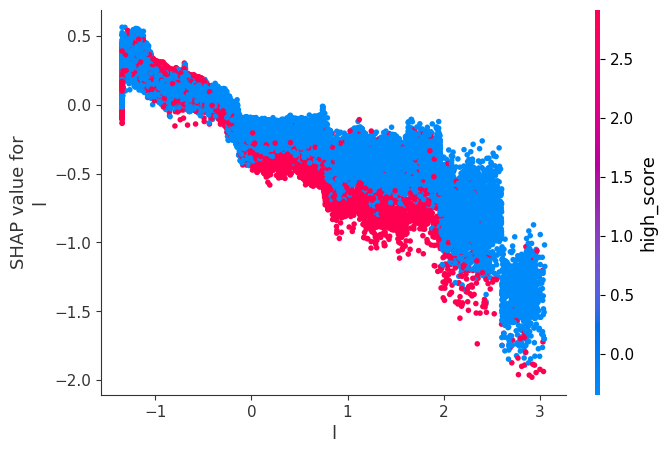

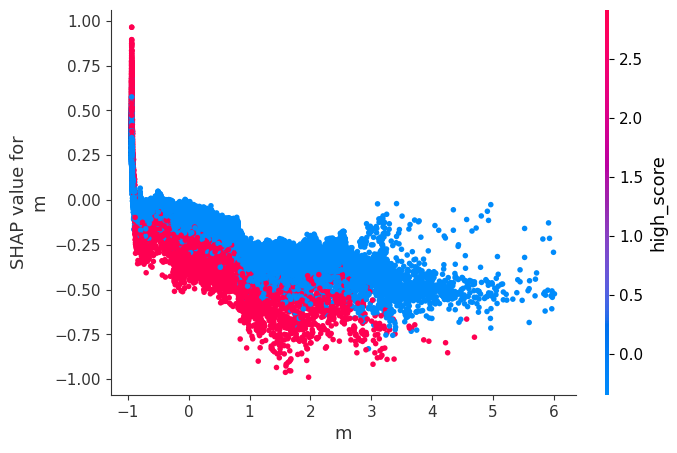

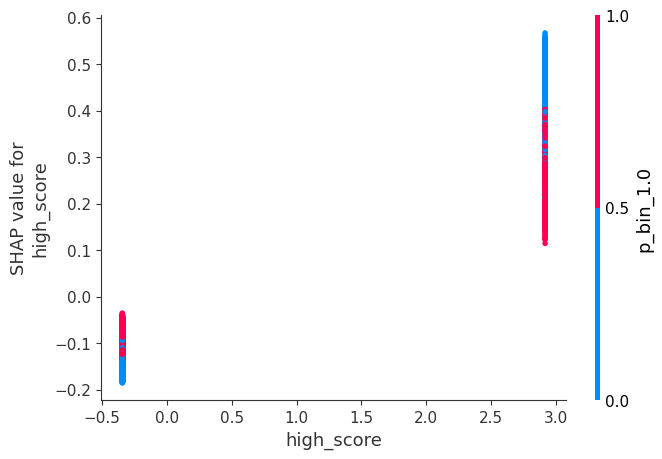

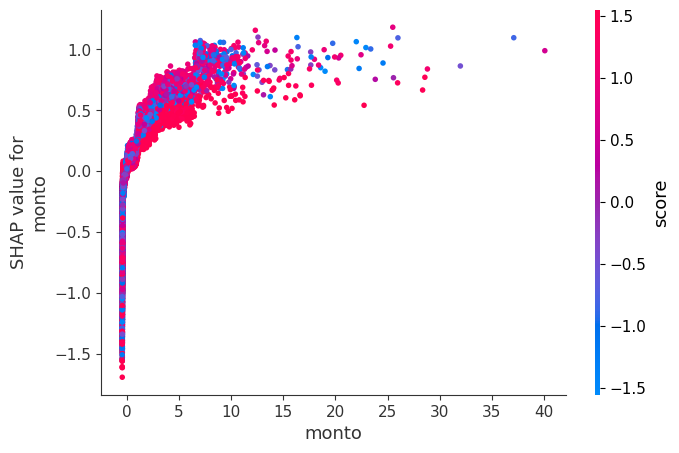

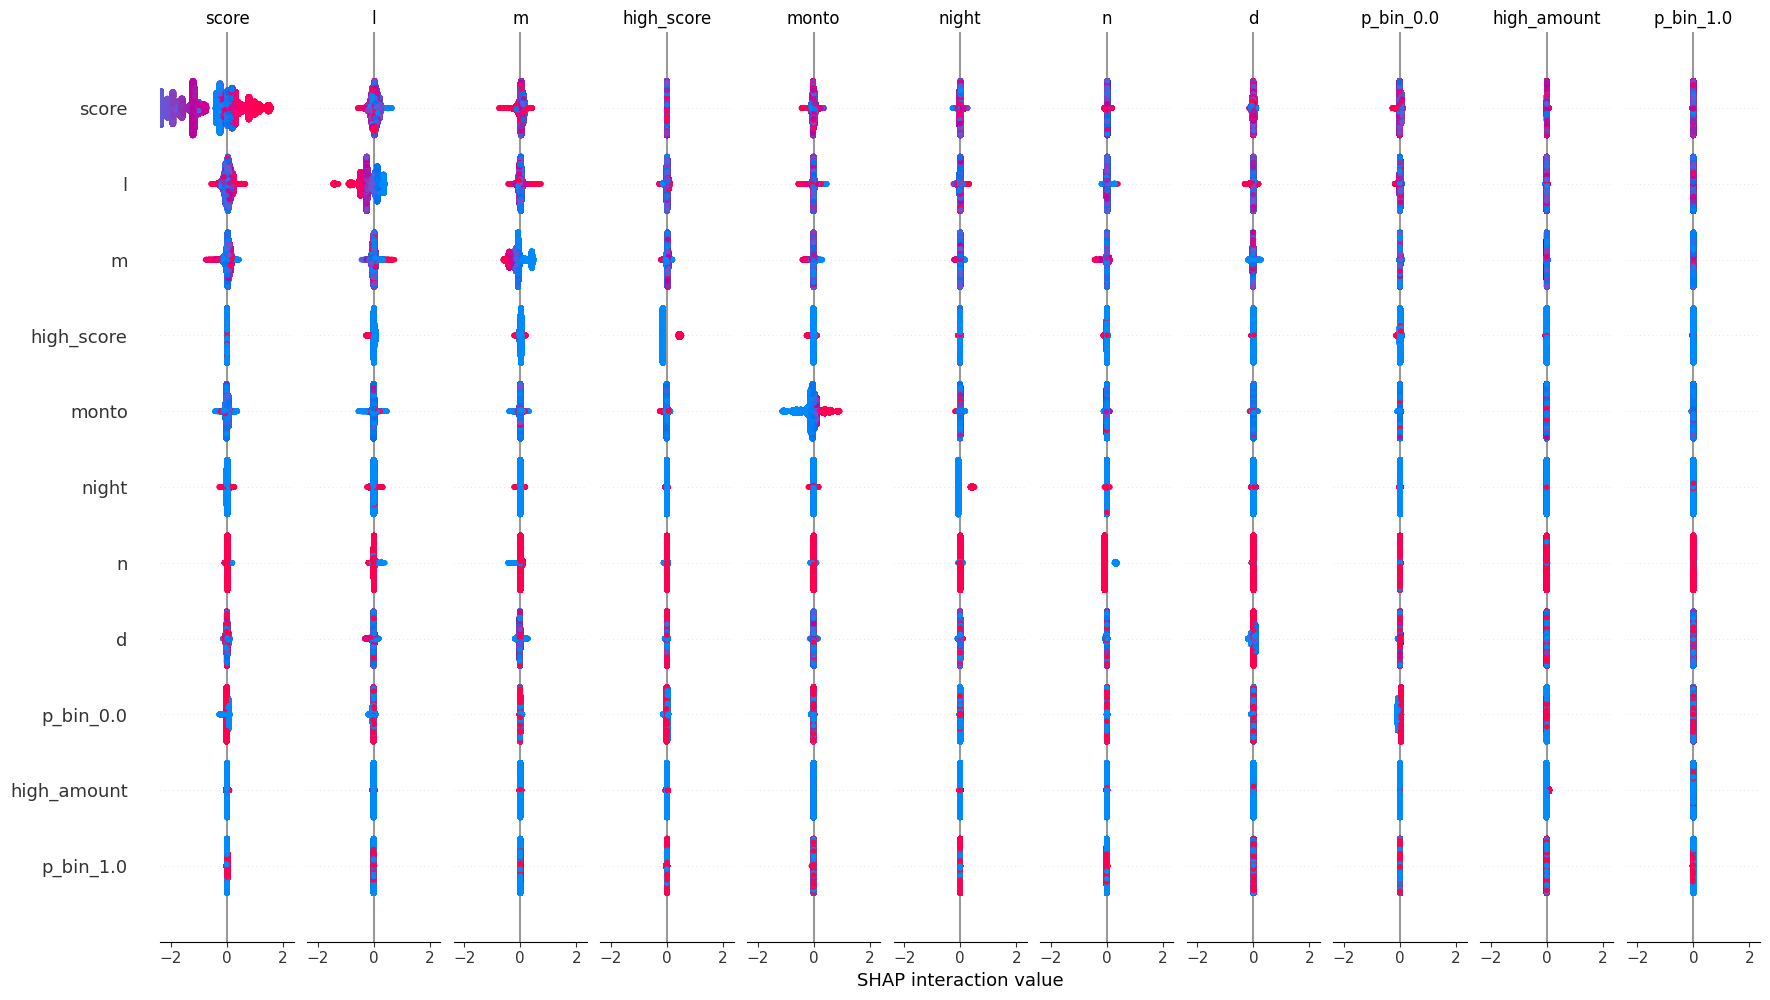

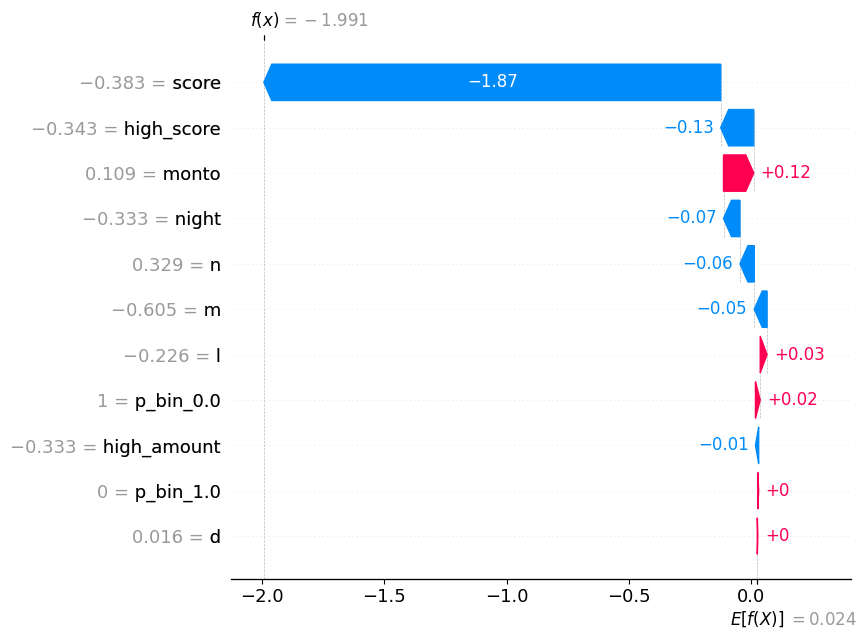

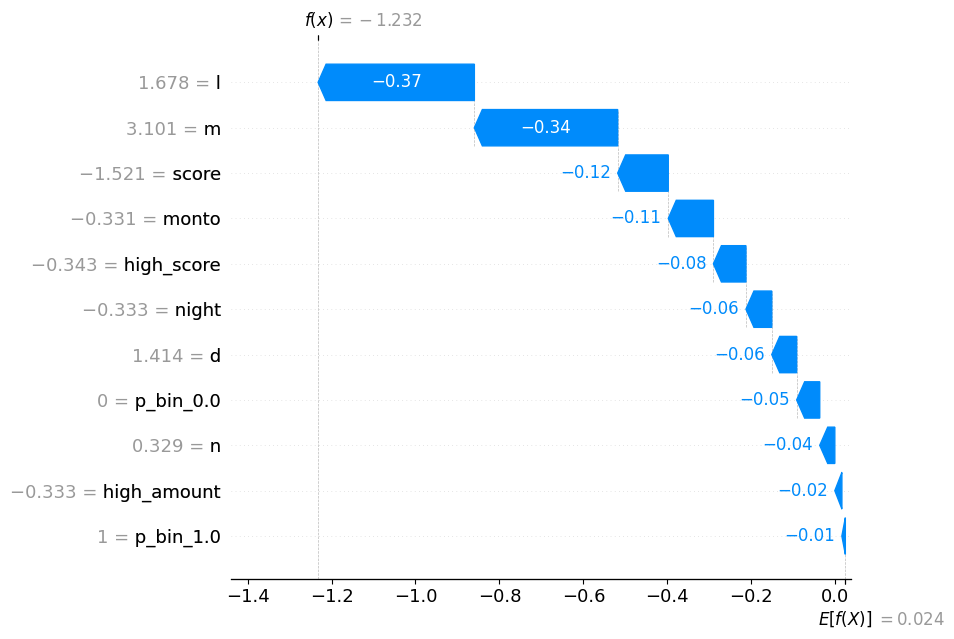

In [119]:
def compute_shap_pipeline(pipeline, X):
    clf = model.named_steps["clf"]
    preprocessor = pipeline[:-1]
    X_train_df = preprocessor.transform(X)
    transformer = model[:-1]["prep"]["preprocessing"]
    names = transformer.get_feature_names_out()
    feat_names = np.array([name.split("__", 1)[-1] for name in names])
    X_train_transformed = pd.DataFrame(X_train_df, columns=feat_names, index=X.index)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(X_train_transformed)

    return explainer, shap_values, X_train_transformed, feat_names

explainer, shap_values, X_train_transformed, names = compute_shap_pipeline(model, X_train)
shap.summary_plot(shap_values, X_train_transformed, show=True)
k = 5
mean_abs = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(mean_abs)[-k:][::-1]
for j in top_idx:
    shap.dependence_plot(names[j], shap_values.values, X_train_transformed, interaction_index="auto", show=True)

S = shap.TreeExplainer(model.named_steps["clf"]).shap_interaction_values(X_train_transformed)
shap.summary_plot(S, X_train_transformed, plot_type="heatmap", max_display=15)
shap.plots.waterfall(shap_values[1], max_display=14)
shap.plots.waterfall(shap_values[100], max_display=14)

